In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import matplotlib
# matplotlib.use("TkAgg")
%matplotlib inline
import matplotlib.pyplot as plt

## 2D dataset

In [3]:
num_points = 100
X1 = np.linspace(-2.5, 1.9, num_points)
# X1 = np.linspace(-2.5, 2.5, num_points)
# X2 = np.linspace(-2.5, 3, num_points)
X2 = np.linspace(-2.2, 2.1, num_points)
X1, X2 = np.meshgrid(X1, X2)
Y = np.sin(np.sqrt(X1**2 + X2**2))*2-1. - 0.1*(X1)+0.02*(X2)

####Scaling the data to range -1,1
X1 = 2*(X1 - X1.min())/(X1.max() - X1.min()) -1
X2 = 2*(X2 - X2.min())/(X2.max() - X2.min()) -1
Y = 2*(Y - Y.min())/(Y.max() - Y.min()) -1
Y = Y/2

x1 = X1.reshape(-1)
x2 = X2.reshape(-1)

xx = torch.Tensor(np.c_[x1, x2])
yy = torch.Tensor(Y.reshape(-1,1))


/tmp/ipykernel_6133/3201775701.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


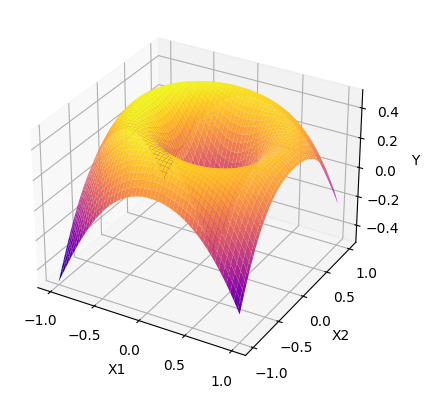

In [4]:
# %matplotlib tk
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X1, X2, Y, cmap='plasma')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
plt.show()

In [5]:
from convex_lib import ConvexNN

In [6]:
from nflib.flows import SequentialFlow, NormalizingFlow, ActNorm
import nflib.res_flow as irf
import nflib

In [7]:
class DistanceRegressor(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        self.bias = nn.Parameter(torch.ones(1)*-0.5)
        self.inv_temp = nn.Parameter(torch.ones(1)*inv_temp)

        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
        x = torch.nn.functional.softplus(x-0.1, beta=5)
#         x = -x*self.inv_temp + self.bias
        x = x*self.inv_temp + self.bias
        return x

In [6]:
EPOCHS = 1000
# actf = nn.LeakyReLU
# actf = nn.ELU
learning_rate = 0.005
criterion = nn.MSELoss()

# Invex NN

In [20]:
# cvxNet = ConvexNN([2, 10, 10, 1], actf)

cvxNet = nn.Sequential(
    nn.BatchNorm1d(2),
    irf.ResidualFlow(2, [10, 15]),
    nn.BatchNorm1d(2),
    DistanceRegressor(2),
)


optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

Epoch: 0, Loss:2.1339969635009766


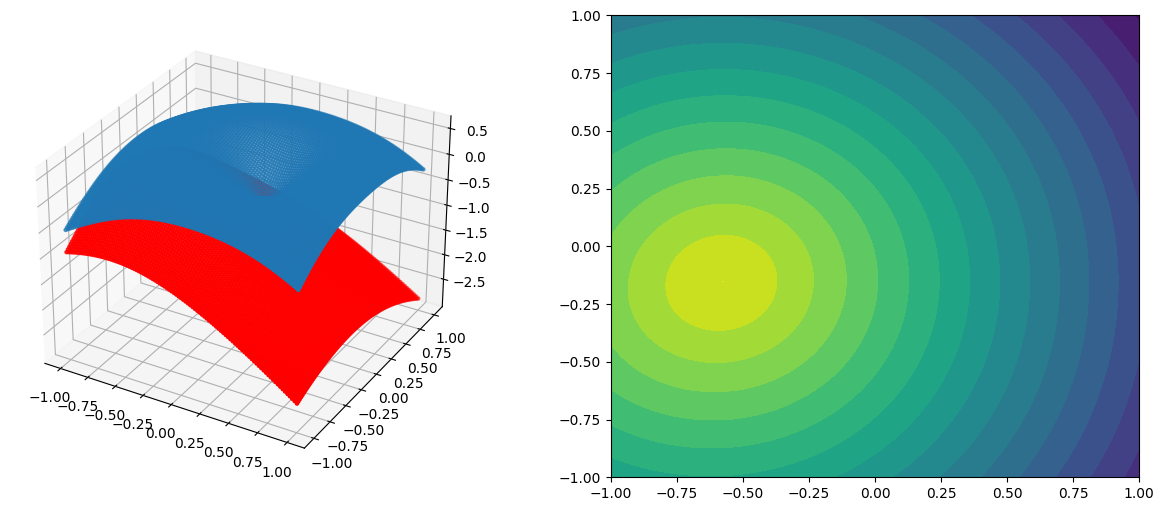

Epoch: 100, Loss:0.04183560609817505
Epoch: 200, Loss:0.021791335195302963
Epoch: 300, Loss:0.022157398983836174
Epoch: 400, Loss:0.018499743193387985
Epoch: 500, Loss:0.018265733495354652
Epoch: 600, Loss:0.01792089268565178
Epoch: 700, Loss:0.016542574390769005
Epoch: 800, Loss:0.016103850677609444
Epoch: 900, Loss:0.015420363284647465
Epoch: 999, Loss:0.01490835566073656


In [21]:
%matplotlib inline
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

/tmp/ipykernel_9307/1236598628.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


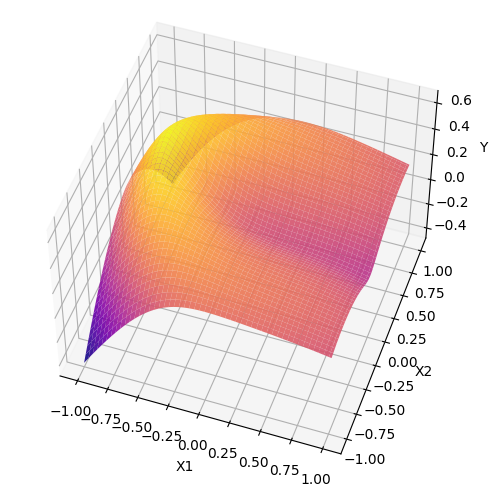

In [22]:
%matplotlib inline

y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

## Plotting Contour Plot

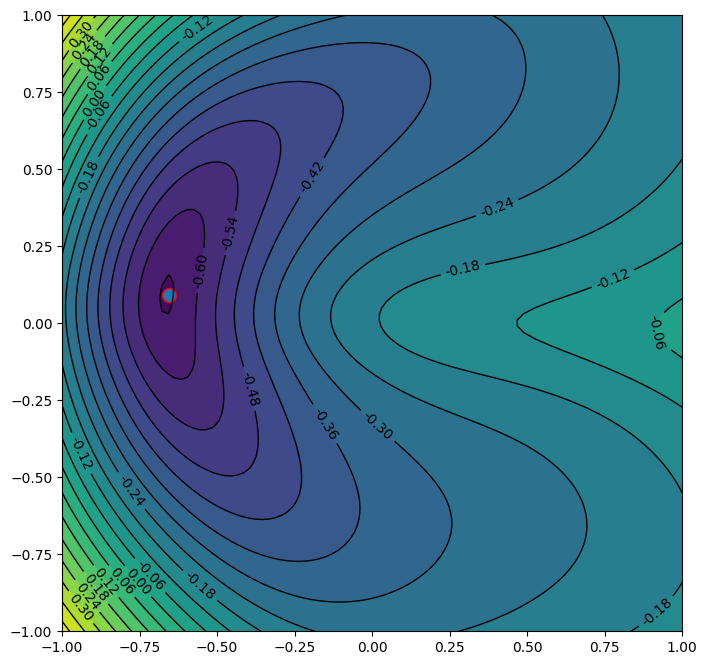

In [23]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

In [24]:
min_val = y_.min()
min_val

-0.66975677

In [25]:
minima = xx[None, y_.argmin()]
minima

tensor([[-0.6566,  0.0909]])

In [26]:
# minima[0, 0] = minima[0, 0] + 0.25
# minima[0, 1] = minima[0, 1] - 0.1

## Finding Mimima by using gradient descent

In [27]:
xmin = minima.clone()
xmin = torch.autograd.Variable(xmin, requires_grad=True)
xmin

tensor([[-0.6566,  0.0909]], requires_grad=True)

In [28]:
optim = torch.optim.Adam([xmin], lr=0.001)
STEPS = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=STEPS)

In [29]:
cvxNet.eval()

Sequential(
  (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ResidualFlow(
    (resblock): ModuleList(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Swish()
      (2): Linear(in_features=10, out_features=15, bias=True)
      (3): Swish()
      (4): Linear(in_features=15, out_features=2, bias=True)
    )
  )
  (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): DistanceRegressor()
)

### Search Loop

In [30]:
for step in range(STEPS):
    optimizer.zero_grad() 

    ymin = cvxNet(xmin)
    xgrad = torch.autograd.grad(outputs=ymin, inputs=xmin, grad_outputs=torch.ones_like(ymin), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xmin.grad = xgrad
    
    optim.step()
    scheduler.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, xmin: {xmin.data}, min_value: {ymin.data}")

STEPS: 0, xmin: tensor([[-0.6576,  0.0919]]), min_value: tensor([[-0.6632]])
STEPS: 100, xmin: tensor([[-0.6732,  0.0914]]), min_value: tensor([[-0.6733]])
STEPS: 200, xmin: tensor([[-0.6729,  0.0914]]), min_value: tensor([[-0.6733]])
STEPS: 300, xmin: tensor([[-0.6731,  0.0915]]), min_value: tensor([[-0.6732]])
STEPS: 400, xmin: tensor([[-0.6731,  0.0916]]), min_value: tensor([[-0.6733]])
STEPS: 500, xmin: tensor([[-0.6729,  0.0914]]), min_value: tensor([[-0.6733]])
STEPS: 600, xmin: tensor([[-0.6731,  0.0915]]), min_value: tensor([[-0.6733]])
STEPS: 700, xmin: tensor([[-0.6731,  0.0916]]), min_value: tensor([[-0.6733]])
STEPS: 800, xmin: tensor([[-0.6729,  0.0914]]), min_value: tensor([[-0.6733]])
STEPS: 900, xmin: tensor([[-0.6731,  0.0915]]), min_value: tensor([[-0.6733]])
STEPS: 1000, xmin: tensor([[-0.6731,  0.0916]]), min_value: tensor([[-0.6733]])
STEPS: 1100, xmin: tensor([[-0.6729,  0.0914]]), min_value: tensor([[-0.6733]])
STEPS: 1200, xmin: tensor([[-0.6731,  0.0915]]), min

In [31]:
xgrad

tensor([[0.4961, 0.0528]], grad_fn=<NativeBatchNormBackwardBackward0>)

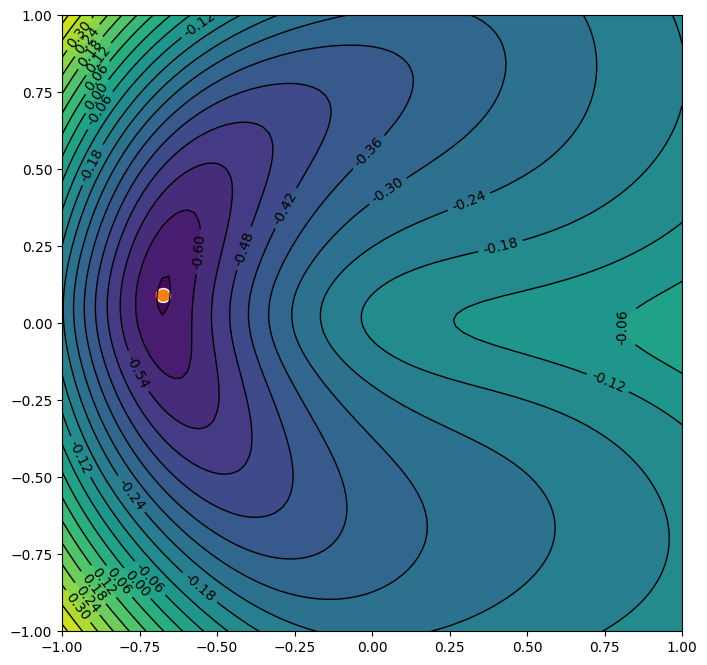

In [32]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")
plt.scatter(*xmin.data[0].tolist(), s=100, edgecolors="white")

In [33]:
minima = xmin.data
min_val = cvxNet(xmin).data[0].item()
minima, min_val

(tensor([[-0.6731,  0.0915]]), -0.6733230352401733)

## Zero-Level Invex Function for refrence

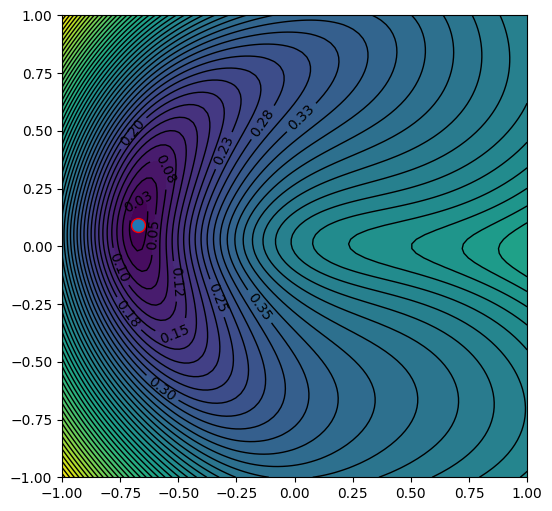

In [34]:
# y_ = cvxNet(xx + minima).data.cpu().numpy().reshape(Y.shape)- min_val
y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape) - min_val

LVLs = 50
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels[:15], inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(*minima[0].tolist(), s=100, edgecolors="red")

### Extracting the Exact Contour 

In [35]:
cvxNet.eval()

Sequential(
  (0): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (1): ResidualFlow(
    (resblock): ModuleList(
      (0): Linear(in_features=2, out_features=10, bias=True)
      (1): Swish()
      (2): Linear(in_features=10, out_features=15, bias=True)
      (3): Swish()
      (4): Linear(in_features=15, out_features=2, bias=True)
    )
  )
  (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): DistanceRegressor()
)

In [36]:
# contour_levels = []

In [37]:
xx.shape

torch.Size([10000, 2])

In [52]:
level = 0.30 # 0.65, 0.25
xx_norm = torch.norm(xx, dim=1, keepdim=True)
xx_ = xx/xx_norm * level

In [53]:
xx_lnorm = torch.ones_like(xx_norm)*0.5
xx_lnorm = torch.autograd.Variable(xx_lnorm, requires_grad=True)
xx_lnorm

tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.5000],
        [0.5000],
        [0.5000]], requires_grad=True)

In [54]:
optimizer = torch.optim.Adam([xx_lnorm], lr=0.03)
STEPS = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS)

In [55]:
minima

tensor([[-0.6731,  0.0915]])

### Training Loop

In [56]:
for step in range(STEPS):
    optimizer.zero_grad() 

    yy_ = torch.abs(cvxNet(xx_*xx_lnorm + minima) - min_val - level)
    xgrad = torch.autograd.grad(outputs=yy_, inputs=xx_lnorm, grad_outputs=torch.ones_like(yy_), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xx_lnorm.grad = xgrad
    
    optimizer.step()
    scheduler.step()    
    
    if step%100 == 0:
        print(f"STEPS: {step}, norm_min: {xx_lnorm.data.min()}, norm_max: {xx_lnorm.data.max()}, min_value: {ymin.data.min()}")

STEPS: 0, norm_min: 0.5299999713897705, norm_max: 0.5300000309944153, min_value: -0.6733230352401733
STEPS: 100, norm_min: 0.8101950883865356, norm_max: 3.3025567531585693, min_value: -0.6733230352401733
STEPS: 200, norm_min: 0.8093962669372559, norm_max: 3.4431912899017334, min_value: -0.6733230352401733
STEPS: 300, norm_min: 0.8091427087783813, norm_max: 3.435490608215332, min_value: -0.6733230352401733
STEPS: 400, norm_min: 0.808121383190155, norm_max: 3.4387762546539307, min_value: -0.6733230352401733
STEPS: 500, norm_min: 0.8078803420066833, norm_max: 3.4373481273651123, min_value: -0.6733230352401733
STEPS: 600, norm_min: 0.8078930377960205, norm_max: 3.4345595836639404, min_value: -0.6733230352401733
STEPS: 700, norm_min: 0.8057718276977539, norm_max: 3.438032627105713, min_value: -0.6733230352401733
STEPS: 800, norm_min: 0.8051687479019165, norm_max: 3.43550181388855, min_value: -0.6733230352401733
STEPS: 900, norm_min: 0.8052985668182373, norm_max: 3.439838171005249, min_value

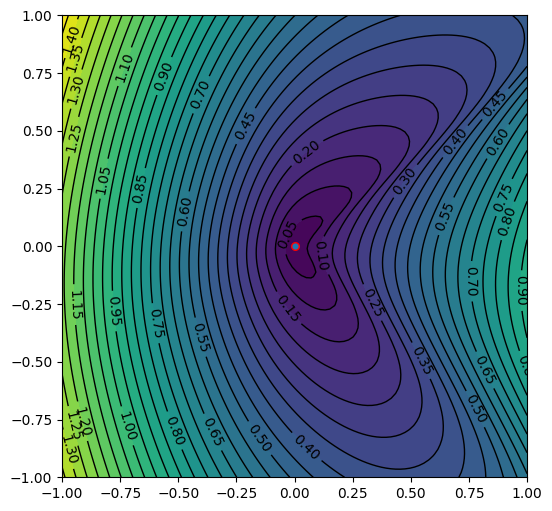

In [57]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 30
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=30, edgecolors="red")

# plt.savefig(f"./outputs/04.0_convex_distance/invex_contour_dist_l{level}.pdf", bbox_inches='tight')

In [58]:
y_.shape

torch.Size([100, 100])

In [59]:
# contour_levels += [level]
# contour_levels = list(set(contour_levels))

## Plotting Triangle Inequality on Distance

In [87]:
a = torch.Tensor([0.54, -0.15])
b = torch.Tensor([0.36, -0.41])

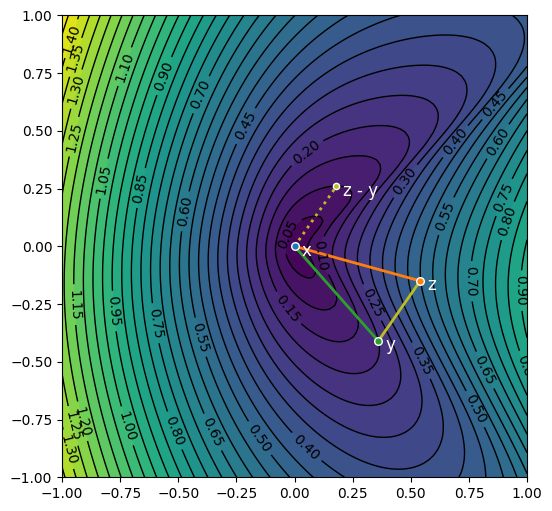

In [89]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 30
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

plt.plot([b[0],a[0]], [b[1],a[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(8))
plt.plot([0,b[0]], [0,b[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(2))
plt.plot([0,a[0]], [0,a[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(1))

diff = [a[0]-b[0], a[1]-b[1]]
plt.plot([0,diff[0]], [0,diff[1]], linestyle='dotted', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(8))


plt.scatter(0, 0, s=30, edgecolors="w", zorder=100)
plt.scatter(a[0], a[1], s=30, edgecolors="w", zorder=100)
plt.scatter(b[0], b[1], s=30, edgecolors="w", zorder=100)
plt.scatter(diff[0], diff[1], s=20, edgecolors="w",
              alpha=1.0, facecolor=matplotlib.cm.tab10(8), zorder=100)


plt.text(0.03, -0.04, 'x', fontsize=12, color='w')
plt.text(a[0]+0.03, a[1]-0.04, 'z', fontsize=12, color='w')
plt.text(b[0]+0.03, b[1]-0.04, 'y', fontsize=12, color='w')
plt.text(diff[0]+0.03, diff[1]-0.04, 'z - y', fontsize=12, color='w')


plt.savefig(f"./outputs/04.3_metric_properties/invex_contour_prop.pdf", bbox_inches='tight')

In [90]:
! mkdir ./outputs/04.3_metric_properties

mkdir: cannot create directory ‘./outputs/04.3_metric_properties’: File exists


## Show triangle inequality on convex

# Convex NN

In [7]:
# actf = nn.LeakyReLU
actf = nn.ELU
cvxNet = ConvexNN([2, 10, 10, 1], actf)

optimizer = torch.optim.Adam(cvxNet.parameters(), lr=learning_rate)

Epoch: 0, Loss:0.5079773664474487


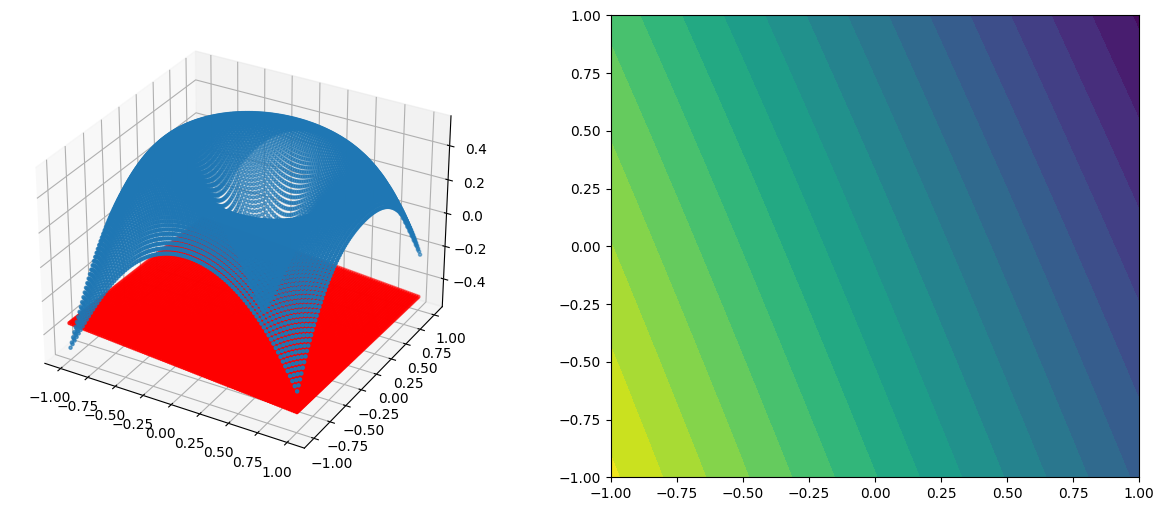

Epoch: 100, Loss:0.032015807926654816
Epoch: 200, Loss:0.029972540214657784
Epoch: 300, Loss:0.026542946696281433
Epoch: 400, Loss:0.023142961785197258
Epoch: 500, Loss:0.021851520985364914
Epoch: 600, Loss:0.020963149145245552
Epoch: 700, Loss:0.020216435194015503
Epoch: 800, Loss:0.019856983795762062
Epoch: 900, Loss:0.019697727635502815
Epoch: 999, Loss:0.01961679384112358
Epoch: 1000, Loss:0.019618026912212372
Epoch: 1100, Loss:0.01954817585647106
Epoch: 1200, Loss:0.0195147804915905
Epoch: 1300, Loss:0.019471021369099617
Epoch: 1400, Loss:0.019439859315752983
Epoch: 1500, Loss:0.01940579153597355
Epoch: 1600, Loss:0.019378958269953728
Epoch: 1700, Loss:0.019349001348018646
Epoch: 1800, Loss:0.01931864582002163
Epoch: 1900, Loss:0.01929541490972042


In [8]:
%matplotlib inline
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122)

for epoch in range(EPOCHS*2):

    yout = -cvxNet(xx)    
    loss = criterion(yout, yy)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch%100 == 0 or epoch==EPOCHS-1:
        print(f'Epoch: {epoch}, Loss:{float(loss)}')
        ax.clear()
        ax.scatter(X1, X2, yy.data.numpy().reshape(-1), marker= '.')
        ax.scatter(X1, X2, yout.data.numpy().reshape(-1), color='r', marker='.')
        ax2.clear()
        ax2.contourf(X1, X2, yout.data.numpy().reshape(Y.shape), levels=20)

        fig.canvas.draw()
        plt.pause(0.01)
plt.close()

/tmp/ipykernel_6133/1236598628.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


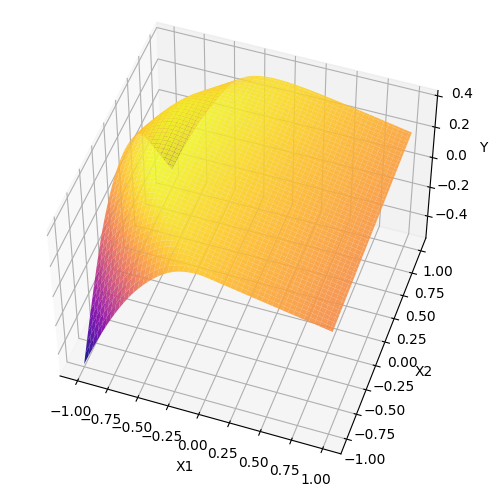

In [9]:
%matplotlib inline

y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

## Plotting Contour Plot

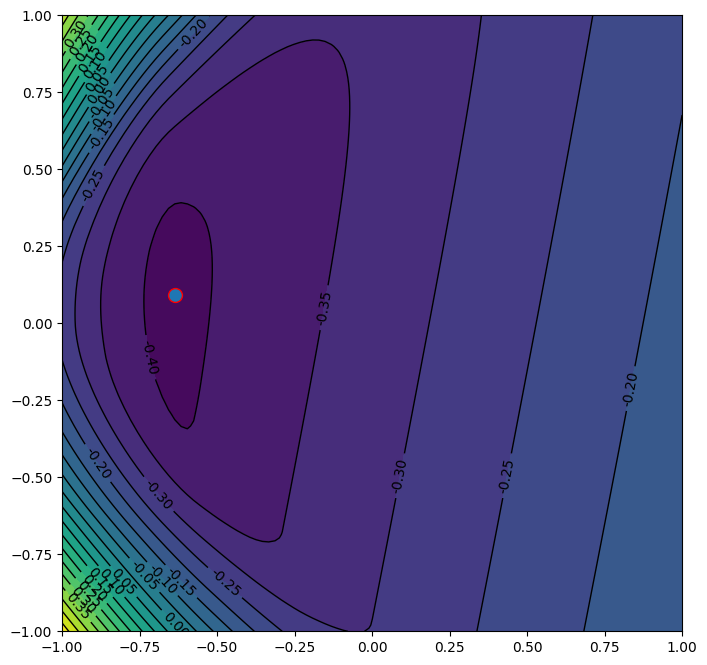

In [10]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")

In [11]:
min_val = y_.min()
min_val

-0.4111997

In [12]:
minima = xx[None, y_.argmin()]
minima

tensor([[-0.6364,  0.0909]])

In [13]:
# minima[0, 0] = minima[0, 0] + 0.25
# minima[0, 1] = minima[0, 1] - 0.1

## Finding Mimima by using gradient descent

In [14]:
xmin = minima.clone()
xmin = torch.autograd.Variable(xmin, requires_grad=True)
xmin

tensor([[-0.6364,  0.0909]], requires_grad=True)

In [15]:
optim = torch.optim.Adam([xmin], lr=0.001)
STEPS = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=STEPS)

In [17]:
cvxNet.eval()

ConvexNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip_layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=2, out_features=1, bias=True)
  )
)

### Search Loop

In [18]:
for step in range(STEPS):
    optimizer.zero_grad() 

    ymin = cvxNet(xmin)
    xgrad = torch.autograd.grad(outputs=ymin, inputs=xmin, grad_outputs=torch.ones_like(ymin), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xmin.grad = xgrad
    
    optim.step()
    scheduler.step()
    
    if step%100 == 0:
        print(f"STEPS: {step}, xmin: {xmin.data}, min_value: {ymin.data}")

STEPS: 0, xmin: tensor([[-0.6374,  0.0919]]), min_value: tensor([[-0.4112]])
STEPS: 100, xmin: tensor([[-0.6377,  0.0985]]), min_value: tensor([[-0.4112]])
STEPS: 200, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 300, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 400, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 500, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 600, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 700, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 800, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 900, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 1000, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 1100, xmin: tensor([[-0.6377,  0.0984]]), min_value: tensor([[-0.4112]])
STEPS: 1200, xmin: tensor([[-0.6377,  0.0984]]), min

In [19]:
xgrad

tensor([[0., 0.]], grad_fn=<AddBackward0>)

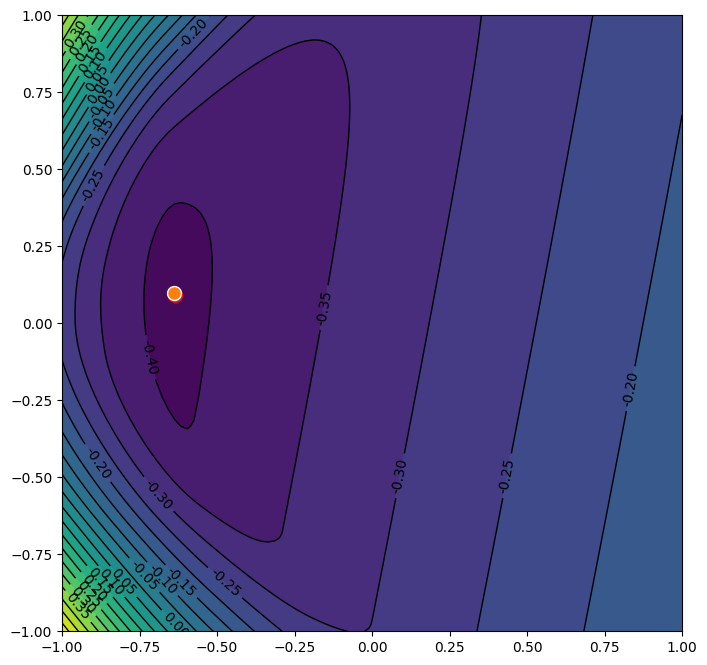

In [20]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
minima = xx[y_.argmin()]
plt.scatter(*minima.tolist(), s=100, edgecolors="red")
plt.scatter(*xmin.data[0].tolist(), s=100, edgecolors="white")

In [21]:
minima = xmin.data
min_val = cvxNet(xmin).data[0].item()
minima, min_val

(tensor([[-0.6377,  0.0984]]), -0.41120684146881104)

## Zero-Level Invex Function for refrence

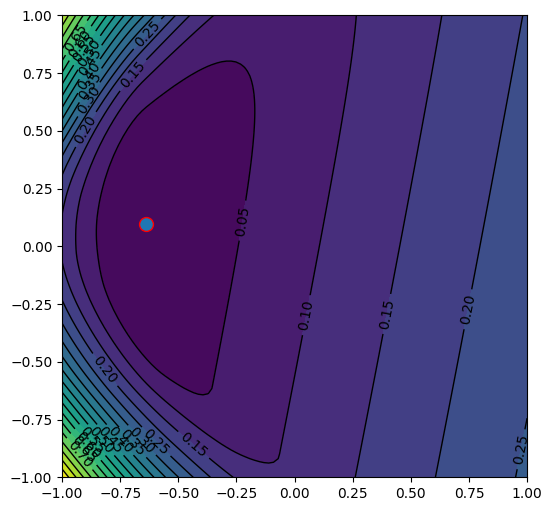

In [22]:
# y_ = cvxNet(xx + minima).data.cpu().numpy().reshape(Y.shape)- min_val
y_ = cvxNet(xx).data.cpu().numpy().reshape(Y.shape) - min_val

LVLs = 20
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels[:15], inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(*minima[0].tolist(), s=100, edgecolors="red")

### Extracting the Exact Contour 

In [23]:
cvxNet.eval()

ConvexNN(
  (layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
  (skip_layers): ModuleList(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [24]:
# contour_levels = []

In [25]:
xx.shape

torch.Size([10000, 2])

In [26]:
level = 0.20 # 0.65, 0.25
xx_norm = torch.norm(xx, dim=1, keepdim=True)
xx_ = xx/xx_norm * level

In [27]:
xx_lnorm = torch.ones_like(xx_norm)*0.5
xx_lnorm = torch.autograd.Variable(xx_lnorm, requires_grad=True)
xx_lnorm

tensor([[0.5000],
        [0.5000],
        [0.5000],
        ...,
        [0.5000],
        [0.5000],
        [0.5000]], requires_grad=True)

In [28]:
optimizer = torch.optim.Adam([xx_lnorm], lr=0.03)
STEPS = 4000
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS)

In [29]:
minima

tensor([[-0.6377,  0.0984]])

### Training Loop

In [30]:
for step in range(STEPS):
    optimizer.zero_grad() 

    yy_ = torch.abs(cvxNet(xx_*xx_lnorm + minima) - min_val - level)
    xgrad = torch.autograd.grad(outputs=yy_, inputs=xx_lnorm, grad_outputs=torch.ones_like(yy_), 
                            only_inputs=True, retain_graph=True, create_graph=True)[0]
    xx_lnorm.grad = xgrad
    
    optimizer.step()
    scheduler.step()    
    
    if step%100 == 0:
        print(f"STEPS: {step}, norm_min: {xx_lnorm.data.min()}, norm_max: {xx_lnorm.data.max()}, min_value: {ymin.data.min()}")

STEPS: 0, norm_min: 0.5299999117851257, norm_max: 0.5299999713897705, min_value: -0.41120684146881104
STEPS: 100, norm_min: 2.0536506175994873, norm_max: 4.848359107971191, min_value: -0.41120684146881104
STEPS: 200, norm_min: 2.048454999923706, norm_max: 8.351692199707031, min_value: -0.41120684146881104
STEPS: 300, norm_min: 2.050736427307129, norm_max: 11.145650863647461, min_value: -0.41120684146881104
STEPS: 400, norm_min: 2.055316686630249, norm_max: 13.344690322875977, min_value: -0.41120684146881104
STEPS: 500, norm_min: 2.0517075061798096, norm_max: 14.128073692321777, min_value: -0.41120684146881104
STEPS: 600, norm_min: 2.0534019470214844, norm_max: 14.131580352783203, min_value: -0.41120684146881104
STEPS: 700, norm_min: 2.054738759994507, norm_max: 14.127471923828125, min_value: -0.41120684146881104
STEPS: 800, norm_min: 2.0539872646331787, norm_max: 14.129213333129883, min_value: -0.41120684146881104
STEPS: 900, norm_min: 2.0503766536712646, norm_max: 14.12777042388916, m

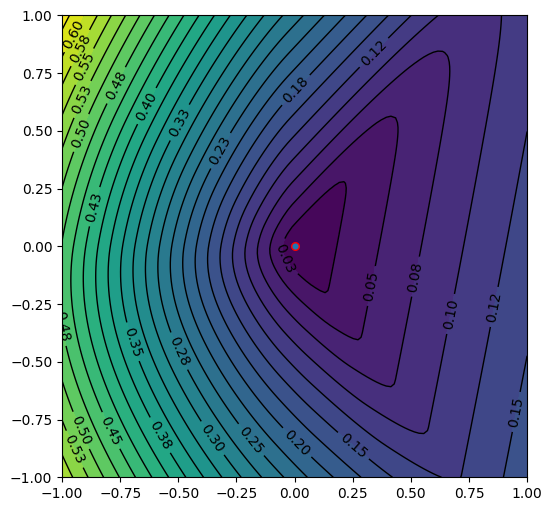

In [31]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 30
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")
plt.scatter(0, 0, s=30, edgecolors="red")

# plt.savefig(f"./outputs/04.0_convex_distance/invex_contour_dist_l{level}.pdf", bbox_inches='tight')

In [32]:
y_.shape

torch.Size([100, 100])

In [33]:
# contour_levels += [level]
# contour_levels = list(set(contour_levels))

## Plotting Triangle Inequality on Distance

In [51]:
a = torch.Tensor([0.3, 0.6])
# b = torch.Tensor([0.0, 0.1])
b = torch.Tensor([0.1, 0.2])

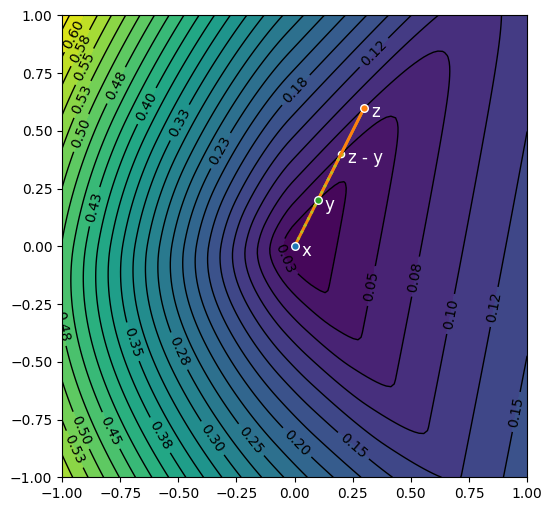

In [52]:
y_ = (xx_norm/xx_lnorm.data).cpu().reshape(X1.shape)

LVLs = 30
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

plt.plot([b[0],a[0]], [b[1],a[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(8))
plt.plot([0,b[0]], [0,b[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(2))
plt.plot([0,a[0]], [0,a[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(1))

diff = [a[0]-b[0], a[1]-b[1]]
plt.plot([0,diff[0]], [0,diff[1]], linestyle='dotted', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(8))


plt.scatter(0, 0, s=30, edgecolors="w", zorder=100)
plt.scatter(a[0], a[1], s=30, edgecolors="w", zorder=100)
plt.scatter(b[0], b[1], s=30, edgecolors="w", zorder=100)
plt.scatter(diff[0], diff[1], s=20, edgecolors="w",
              alpha=1.0, facecolor=matplotlib.cm.tab10(8))


plt.text(0.03, -0.04, 'x', fontsize=12, color='w')
plt.text(a[0]+0.03, a[1]-0.04, 'z', fontsize=12, color='w')
plt.text(b[0]+0.03, b[1]-0.04, 'y', fontsize=12, color='w')
plt.text(diff[0]+0.03, diff[1]-0.04, 'z - y', fontsize=12, color='w')

plt.savefig(f"./outputs/04.3_metric_properties/convex_contour_prop.pdf", bbox_inches='tight')

# Show triangle inequality on non-linear radial distance

In [166]:
class Distance(nn.Module):
    def __init__(self, input_dim, inv_temp=1):
        super().__init__()
        self.centers = nn.Parameter(torch.rand(1, input_dim)*2-1)
        
    def forward(self, x):
        x = torch.norm(x-self.centers, dim=-1, keepdim=True)
        return x

In [167]:
distNet = Distance(2)
distNet.centers.data *= 0.

/tmp/ipykernel_9307/3533103887.py:7: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


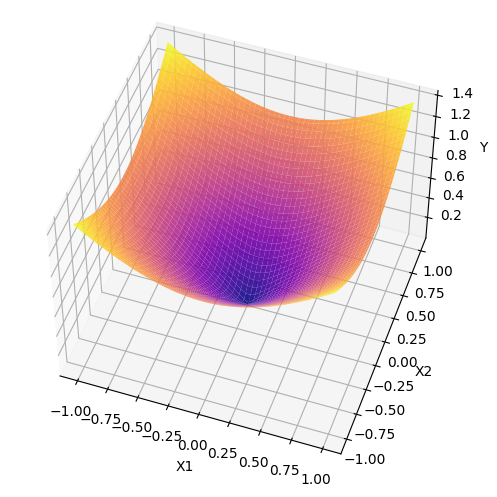

In [168]:
%matplotlib inline

yout = distNet(xx)
y_ = yout.data.cpu().numpy().reshape(Y.shape)

fig = plt.figure(figsize=(8,6))
ax = fig.gca(projection='3d')
ax.view_init(49, -71)
ax.plot_surface(X1, X2, y_, cmap='plasma', alpha=0.9)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('Y')
# plt.pause(0.1)
plt.show()

## Plotting Contour Plot

In [180]:
def scale_above(y, scale=5, above=0.6):
    return torch.maximum(y, scale*(y-above)+above)

<a list of 37 text.Text objects>

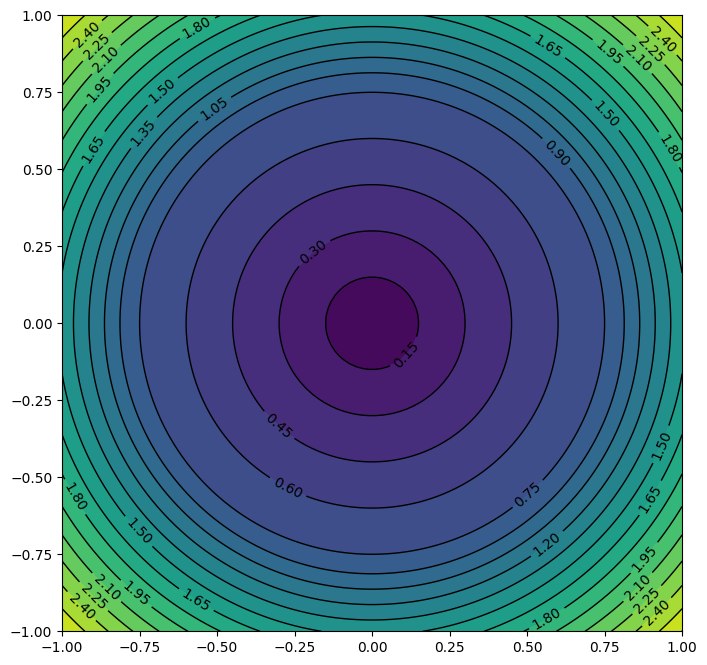

In [185]:
# LVLs = np.linspace(sim.min(), sim.max(), 20)
LVLs = 20

y_ = scale_above(distNet(xx), 3, 0.77).data.cpu().numpy().reshape(Y.shape)

plt.figure(figsize=(8,8))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels, inline=True, fontsize=10, fmt="%1.2f")

In [186]:
min_val = y_.min()*0
min_val

0.0

In [187]:
minima = xx[None, y_.argmin()]*0
minima

tensor([[-0., -0.]])

## Plotting Triangle Inequality on Distance

In [218]:
a = torch.Tensor([0.593, -0.593])
b = torch.Tensor([0.0, -0.5])

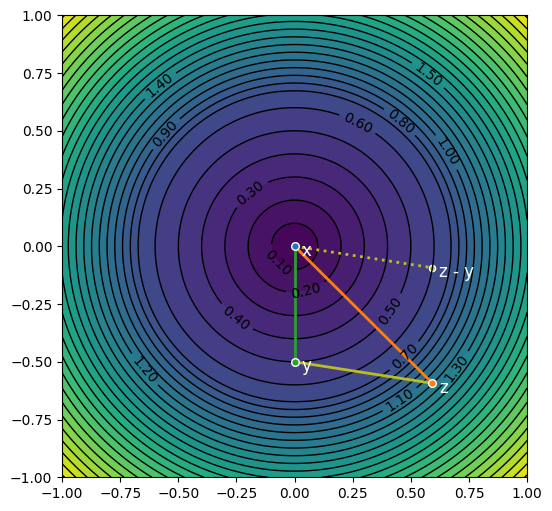

In [219]:
y_ = scale_above(distNet(xx), 3, 0.66).data.cpu().numpy().reshape(X1.shape)

LVLs = 30
plt.figure(figsize=(6,6))
plt.contourf(X1, X2, y_, levels=LVLs)
cs = plt.contour(X1, X2, y_, levels=LVLs, linestyles="None", colors="k", linewidths=1)
plt.clabel(cs, cs.levels[:-15], inline=True, fontsize=10, fmt="%1.2f")

plt.plot([b[0],a[0]], [b[1],a[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(8))
plt.plot([0,b[0]], [0,b[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(2))
plt.plot([0,a[0]], [0,a[1]], linestyle='solid', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(1))

diff = [a[0]-b[0], a[1]-b[1]]
plt.plot([0,diff[0]], [0,diff[1]], linestyle='dotted', linewidth=2,
              alpha=1.0, color=matplotlib.cm.tab10(8))


plt.scatter(0, 0, s=30, edgecolors="w", zorder=100)
plt.scatter(a[0], a[1], s=30, edgecolors="w", zorder=100)
plt.scatter(b[0], b[1], s=30, edgecolors="w", zorder=100)
plt.scatter(diff[0], diff[1], s=20, edgecolors="w",
              alpha=1.0, facecolor=matplotlib.cm.tab10(8))


plt.text(0.03, -0.04, 'x', fontsize=12, color='w')
plt.text(a[0]+0.03, a[1]-0.04, 'z', fontsize=12, color='w')
plt.text(b[0]+0.03, b[1]-0.04, 'y', fontsize=12, color='w')
plt.text(diff[0]+0.03, diff[1]-0.04, 'z - y', fontsize=12, color='w')

plt.savefig(f"./outputs/04.3_metric_properties/l2_nonlinear_contour_prop.pdf", bbox_inches='tight')